In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sae_lens import SAE, HookedSAETransformer
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
import json

with open("synth_data_v2.json","r") as f:
    corpse = json.loads(f.read())
trainset = []
for i in corpse:
    try:
        trainset.append(json.loads(i)['text'])
    except:
        continue
print(f"Train set size: {len(trainset)}")

Train set size: 20746


In [71]:
# model
class FASG_Model(nn.Module):
    def __init__(self,device="cuda:0"):
        super(FASG_Model, self).__init__()

        self.device = device
        self.bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bertModel = BertModel.from_pretrained("bert-base-uncased").to(self.device)
        self.linear = torch.nn.Linear(768, 768).to(self.device)
        self.llm = HookedSAETransformer.from_pretrained("gpt2-small", device=self.device)
        self.sae, cfg_dict, sparsity = SAE.from_pretrained(
            release="gpt2-small-res-jb-feature-splitting",  
            sae_id="blocks.8.hook_resid_pre_768", 
            device=self.device,
        )
        self.top_p = 0.95
        self.temperature = 0.2
        
    def bert_tokenize(self,text):
        return self.bertTokenizer(text,padding=True,truncation=True,return_tensors="pt").to(device = self.device)
        
    def forward(self, encoded_input,prompt,return_type = "str"):
        steering_vector = self.bertModel(**encoded_input).pooler_output

        def steering_features(value, hook,steering_vector = steering_vector,steering_weights = 4):
            #encoded_activation = self.sae.encode(value)
            #steered_vector = steering_vector.unsqueeze(1)*encoded_activation 
            delta_activation = self.sae.decode(steering_vector)

            steered_activation = delta_activation.unsqueeze(1)*steering_weights + value
            
            return steered_activation
    
        fwd_hooks=[(
            'blocks.8.hook_resid_pre', 
            steering_features
        )]

        tokenized_prompt = self.llm.to_tokens(prompt)
        with self.llm.hooks(fwd_hooks=fwd_hooks):
            steered_tokens = self.llm.generate(
            tokenized_prompt,
            max_new_tokens=64,
            temperature=self.temperature,
            top_p=self.top_p,
            stop_at_eos = True,
            return_type = return_type,
            verbose = False
        )
        return steered_tokens

    def llm_generate(self,prompt,return_type = "str"):
        tokenized_prompt = self.llm.to_tokens(prompt)
        generated_tokens = self.llm.generate(
            tokenized_prompt,
            max_new_tokens=64,
            temperature=self.temperature,
            top_p=self.top_p,
            stop_at_eos = True,
            return_type = return_type,
            verbose = False
        )
        return generated_tokens
        

    def freeze_llm_and_sae(self):
        for param in self.llm.parameters():
            param.requires_grad = False
        for param in self.sae.parameters():
            param.requires_grad = False


In [72]:
model = FASG_Model()
sample = trainset[5]

reference_text = sample
prompt = " ".join(sample.split(" ")[:5])
prompt

Loaded pretrained model gpt2-small into HookedTransformer


'Yeah, but most folks think'

In [73]:
model.llm_generate(prompt)

"Yeah, but most folks think that's a good thing.\n\nI'm not sure what you're talking about.\n\nI'm not sure what you're talking about.\n\nI'm not sure what you're talking about.\n\nI'm not sure what you're talking about.\n\nI'm not sure what you're talking"

In [74]:
def steering_features(value, hook,steering_vector = steering_vector):
    out = value + 0.1*steering_vector.unsqueeze(1)
    return out

fwd_hooks=[(
    'blocks.8.hook_resid_pre', 
    steering_features
)]

tokenized_prompt = model.llm.to_tokens(prompt)
with model.llm.hooks(fwd_hooks=fwd_hooks):
    steered = model.llm.generate(
    tokenized_prompt,
    max_new_tokens=64,
    temperature=0.2,
    top_p=0.95,
    stop_at_eos = True,
    return_type = "str",
    verbose = False
)
print(steered)

NameError: name 'steering_vector' is not defined

In [86]:
model.llm.forward(prompt, loss=True, return_type='both')

TypeError: HookedTransformer.forward() got an unexpected keyword argument 'loss'

# t test|

In [75]:
model = FASG_Model()

def get_steered_output(model, prompt, steering_vector):
    steering_vector = steering_vector
    
    def steering_features(value, hook,steering_vector = steering_vector):
        out = value + 0.1*steering_vector.unsqueeze(1)
        return out
    
    fwd_hooks=[(
        'blocks.8.hook_resid_pre', 
        steering_features
    )]
    
    tokenized_prompt = model.llm.to_tokens(prompt)
    with model.llm.hooks(fwd_hooks=fwd_hooks):
        steered = model.llm.generate(
        tokenized_prompt,
        max_new_tokens=64,
        temperature=0.2,
        top_p=0.95,
        stop_at_eos = True,
        return_type = "str",
        verbose = False
    )
    return steered

Loaded pretrained model gpt2-small into HookedTransformer


In [76]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util as st_util


def get_cos_sim(st_model,text1,text2):
    tokenized_inputs = st_model.tokenize(
                [text1,text2])
    for key in tokenized_inputs.keys():
        tokenized_inputs[key] = tokenized_inputs[key].to("cuda:0")
    embeddings = st_model(tokenized_inputs)['sentence_embedding']
    sim = st_util.cos_sim(embeddings[0], embeddings[1])
    return sim

In [82]:
# metrics
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_dict_control = {"rouge1":[],
             "rouge2":[],
             "rougeL":[]}

rouge_dict_treatment = {"rouge1":[],
             "rouge2":[],
             "rougeL":[]}
cos_sim_control = []
cos_sim_treatment = []
outputs = []

# top 10 features
top_features = [698, 734, 709, 719,  87, 112, 675, 679, 187, 445]
num_steered_features = 5
steering_strength = 6
prompt_token_end = 5
st_model = SentenceTransformer("all-MiniLM-L6-v2")

for sample in tqdm(trainset[:100]):
    prompt = " ".join(sample.split(" ")[:prompt_token_end])

    unsteered_reference = model.llm_generate(prompt)
    unsteered_reference = " ".join(unsteered_reference.split(" ")[prompt_token_end:])

    unsteered_control = model.llm_generate(prompt)
    unsteered_control  = " ".join(unsteered_control.split(" ")[prompt_token_end:])
    
    steering_vec = np.zeros(768,dtype = np.float32)
    steering_vec[top_features[:num_steered_features]] = steering_strength
    steering_vec = torch.tensor(steering_vec).unsqueeze(0).to("cuda:0")

    delta_activation = model.sae.decode(steering_vec)
    steered_output = get_steered_output(model, prompt,delta_activation)
    steered_output = " ".join(steered_output.split(" ")[prompt_token_end:])
    
    outputs.append((unsteered_reference,steered_output))

    # rouge
    rouge_scores_treatment = scorer.score(unsteered_reference, steered_output)
    for key in rouge_dict_treatment.keys():
        rouge_dict_treatment[key].append(rouge_scores_treatment[key].fmeasure)

    rouge_scores_control = scorer.score(unsteered_reference, unsteered_control)
    for key in rouge_dict_control.keys():
        rouge_dict_control[key].append(rouge_scores_control[key].fmeasure)
    

    # cos sim
    cos_sim_control.append(get_cos_sim(st_model,unsteered_output,unsteered_control).cpu().detach().numpy()[0][0])
    cos_sim_treatment.append(get_cos_sim(st_model,unsteered_output,steered_output).cpu().detach().numpy()[0][0])

100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


(array([ 3., 15., 22., 22., 12.,  9.,  5.,  4.,  4.,  4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

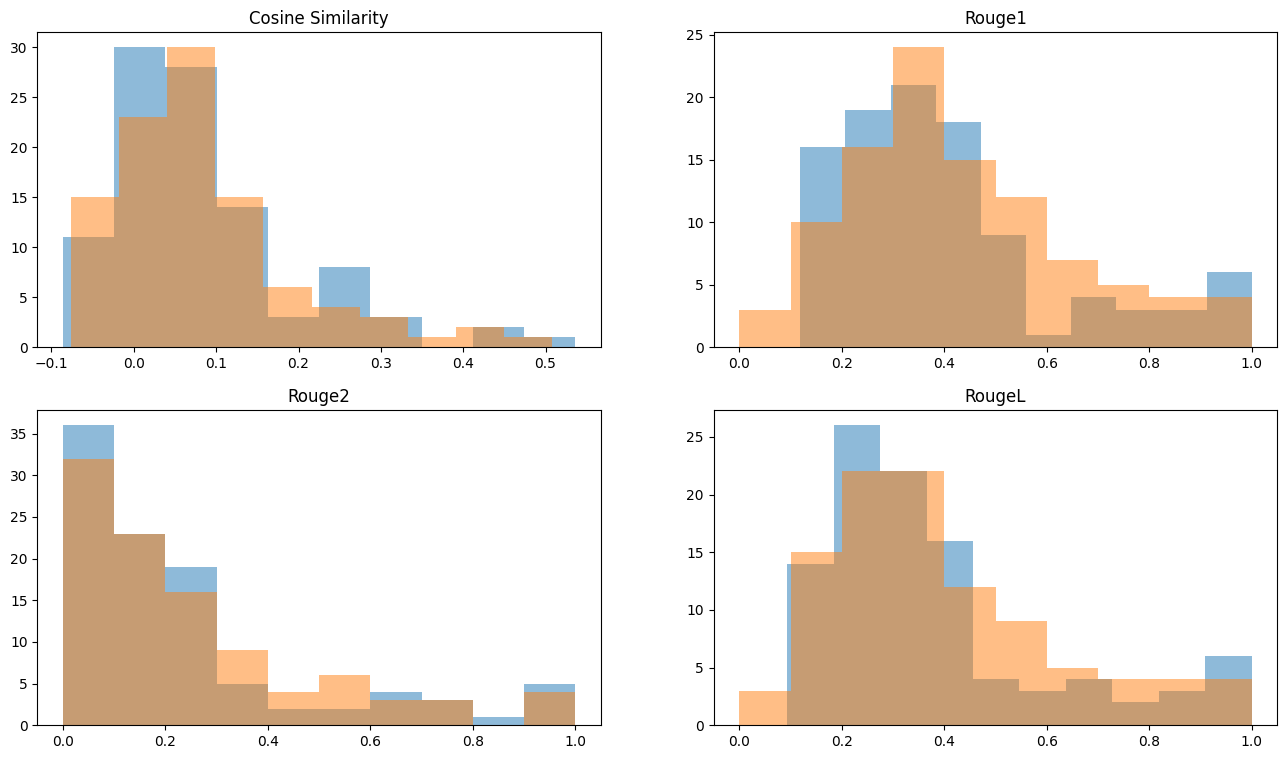

In [78]:
fig, axs = plt.subplots(2,2,figsize=(16,9))
axs[0, 0].set_title('Cosine Similarity')
axs[0,0].hist(cos_sim_treatment,alpha = 0.5)
axs[0,0].hist(cos_sim_control,alpha = 0.5)

axs[0, 1].set_title('Rouge1')
axs[0,1].hist(rouge_dict_treatment['rouge1'],alpha = 0.5)
axs[0,1].hist(rouge_dict_control['rouge1'],alpha = 0.5)

axs[1, 0].set_title('Rouge2')
axs[1,0].hist(rouge_dict_treatment['rouge2'],alpha = 0.5)
axs[1,0].hist(rouge_dict_control['rouge2'],alpha = 0.5)

axs[1, 1].set_title('RougeL')
axs[1,1].hist(rouge_dict_treatment['rougeL'],alpha = 0.5)
axs[1,1].hist(rouge_dict_control['rougeL'],alpha = 0.5)

In [83]:
import scipy.stats as stats

# Perform the one-sample t-test
print("cos sim")
t_statistic, p_value = stats.ttest_rel(cos_sim_control,cos_sim_treatment)

print("P-value:", p_value)

for key in rouge_dict_control.keys():
    print(key)
    t_statistic, p_value = stats.ttest_rel(rouge_dict_control[key],rouge_dict_treatment[key])
    print("P-value:", p_value)
    



cos sim
P-value: 0.58852087944595
rouge1
P-value: 0.36371874785186564
rouge2
P-value: 0.39178001136797513
rougeL
P-value: 0.2593260492575281


In [67]:
rouge_dict_control['rouge2']

[0.16666666666666669,
 0.06837606837606838,
 0.13559322033898305,
 0.24561403508771928,
 0.3584905660377358,
 0.24000000000000002,
 0.05309734513274336,
 0.22857142857142856,
 0.08,
 0.03738317757009346,
 0.08547008547008547,
 0.12280701754385964,
 0.5470085470085471,
 0.39655172413793105,
 0.14545454545454545,
 0.08,
 0.4587155963302752,
 0.24528301886792453,
 0.36363636363636365,
 0.0,
 0.08080808080808081,
 0.52,
 0.17094017094017094,
 0.4888888888888889,
 0.07476635514018691,
 0.0,
 0.22018348623853212,
 0.16867469879518074,
 0.18181818181818182,
 0.05555555555555556,
 0.06122448979591836,
 0.055045871559633024,
 0.27956989247311825,
 0.09259259259259259,
 0.14545454545454545,
 0.6722689075630253,
 0.12612612612612611,
 0.34951456310679613,
 0.018348623853211007,
 0.058823529411764705,
 0.020618556701030927,
 0.6,
 1.0,
 0.025974025974025976,
 0.10526315789473685,
 0.0,
 0.3076923076923077,
 0.24761904761904763,
 0.023529411764705882,
 0.0,
 0.01639344262295082,
 0.5252525252525253